## Versions
Facility Location Model Versions:
* V1: Includes objective: transport costs
* V2: Includes allocation of locations to supply hubs
* V3: Includes objective: opening costs
* V4: Simplification of allocation matrix: - 
    * All Facility locations are allocated to closest supply point - Validated
    * All Demand points are allocated to closest FL if within max. covering range - Validated
* V5: Implementation of coverage objectives - including full uncertainty matrix distances: cumbersome
* V6: Implementation of Delivery Times
* V7: Some improvements on model: 
    - Great circle distance

EMA & Platypus optimisation Versions:
* V1: includes optimisation via Platypus
* V2: included model completely in ema_workbench environment
* V3: Working single run EMA
* V4: Implemented use of kwargs: Levers and case instantiation. Case is now instantiated outside model, by ema uncertainties and ema constant 
* V5: Start algorithm: one case. uncertainties. solutions. robustness. clustering. --> branching

Documentation in Jupyter Notebook:
* V1: Added linear programming model in formulas
* V2: Clean and reorganise notebook
* V3: Moving model documentation to report:<br>
    * This implies that from here onwards, documentation in report is more up-to-date than this jupyter notebook


# TODO

TODO: Organise this to 1FLM, 2EMA,3Doc

Choices:
- Capacitated vs uncapacitated?
- Endogenous vs exogenous number of facilities each optimisation step 
    - each increment: exogenous
    - Full network: endogenous


## FLM:
- Optional: Formulate objective of social cost (or deprivation costs) mathematically and include in model
- XX: Look at Objective Equity. See report.

## Python Implementation & EMA:
- Implement all objectives
- Now Coordinates are uncertainties, to produce new cases as scenarios. --> Generate first, then load as constant.
- Distances as random variables

## DOC:

- Clean document. Everything move to LaTex
- allocation: make sure all FL are connected to a SP - TODO
    - Solution 1 - SP to FL -- Found in Maharjan Hanaoka 2018:
        - <b>Allocation of hubs to supply point is directly. Not via other hubs </b>
        - Easiest and also assumed in other models. Also easy to argue for.
    - Solution 2 
        - <b>for each demand poind point: go to closest</b>
        - for each FL: Too Complicated
            - if angle to SP via FLX is larger than 90degrees: go via FLX
            - if angle to SP via FLX is smaller than 90degrees: go directly
  


Do later, or for further research:
- implement multiple types of allocation (this way, or covering tour), 


# Model XLRM

* External factors
* Levers
* Relations
* Metrics of performance

## External Factors: Define model

- Typography
- disruptions
- demand landscape
- segmented population

# EMA model evaluator



## EMA pseudocode

    
    Sequence of analysis:
        Initialise case (input1,input2,input3) #demand_landscape, 
        Optimise (obj1,obj2,obj3)
        Check Robustness (unc1,unc2,unc3)
        Implement best option

        Change uncertainties based on new information due to new FL
            Do this by reducing uncertainty the most for demand points closer to their preferred DC

    Merge: info up, info down
    
    Define classes
    Generate case
        create locations
    Load EMA model
        specifies:
            demand landscape
            unit transport costs
            unit opening costs
            Max nr of FL to be opened
        calculates
            distances
            allocation
            demand (allocated) XX TODO
            objectives
            

## Incremental Facility Location Algorithm EMA

    Start at starting point.
        For each branch:
            Run with best estimates uncertainties: all policies
            For each non-dominated policy:
                Run all scenarios, one policy
                Calculate robustness score
            Compare robustness scores
            if max locations has been implemented:
                finish branch 
            else: 
                Create new branches with chosen policies
            

## Model functions

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# import ema_workbench as em
from ema_workbench import (Model, RealParameter, IntegerParameter, Constant, ScalarOutcome, ema_logging,
                           perform_experiments, Scenario, Policy, Constraint)

# For vincenty:
from geopy.distance import great_circle



In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### Define classes and Case settings

In [3]:
# Classes
class demand_class:
    """Demand points such as affected cities or villages"""

    def __init__(self, name, x, y, demand):
        self.name = "DP{}".format(name)
        self.type = "demand"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.demand = demand


class supply_class:
    """Supply points such as airports or seaports"""

    def __init__(self, name, x, y, supply):
        self.name = "SP{}".format(name)
        self.type = "supply"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.supply = supply
        self.operational = 1


class facility_class:
    """(Temporary) Distribution centers to distribute supply to demand"""

    def __init__(self, name, x, y):
        self.name = "FL{}".format(name)
        self.type = "facility"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.operational = 0


# Case settings / Globals
# size_area = 10
# nr_demand_points = 10
# nr_supply_points = 1
# nr_optional_FL = 10

### Functions for Instantiating case and calculating objectives

In [4]:
# Instantiate case functions
# Instantiate model


# Create airport as a supply point
def create_supply_points(sup_xcors, sup_ycors, supply_at_sp=100):

    #TODO get a list with specific supply values for each point
    supply_at_sps = [supply_at_sp for i in range(len(sup_xcors))]

    supply_points = []
    for i in range(len(sup_xcors)):
        supply_points.append(
            supply_class(
                name=i,
                x=sup_xcors[i],
                y=sup_ycors[i],
                supply=supply_at_sps[i]))
    return supply_points


# Create demand points
def create_demand_points(dp_xcors, dp_ycors, demand_at_dp=10):

    demand_at_dps = [demand_at_dp for i in range(len(dp_xcors))]

    demand_points = []
    for i in range(len(dp_xcors)):
        demand_points.append(
            demand_class(
                name=i, x=dp_xcors[i], y=dp_ycors[i], demand=demand_at_dps[i]))
    return demand_points


# # Create possible facility locations
def create_facility_locations(fl_xcors, fl_ycors):

    facility_locations = []
    for i in range(len(fl_xcors)):
        facility_locations.append(
            facility_class(name=i, x=fl_xcors[i], y=fl_ycors[i]))
    return facility_locations


# Create matrix with all distances
def create_distance_matrix(all_nodes, distance_to_self=999):
    """
    Creates a matrix with distances between all nodes
    Input: list of all nodes (objects)
    Output: Matrix with distances from [i,j]
    i,j = from, to
    Note: Matrix is symmetric: distances[i,j] = distances[j,i]
    Note: Distance to self ([i,i]) is 100 times larger than largest distance in matrix
    """
    distances = np.zeros([len(all_nodes), len(all_nodes)])

    def calculate_distance(x1, y1, x2, y2, method="euclidean"):
        
        """
        Lat = Y Long = X
        (lat, lon) is coordinate notation used by geopy
        method: euclidean or great_circle
        great_circle returns length in meters
        """
        if method == "euclidean":
            dx = x1 - x2
            dy = y1 - y2
            return (dx**2 + dy**2)**0.5
        
        if method == "great_circle":
            # Geopy uses location order: Lat, Lon
            return great_circle((y1,x1),(y2,x2)).km


    # calculate distance matrix
    for i in range(len(all_nodes)):  #For every row
        for j in range(len(all_nodes)):  #For every column
            distances[i, j] = calculate_distance(
                all_nodes[i].x, all_nodes[i].y, all_nodes[j].x, all_nodes[j].y)

    # set distance to self to big distance
    for i in range(len(distances)):
        distances[i, i] = distance_to_self

    return distances


def create_disrupted_road_matrix(distances, multipliers, nodes):
    """
    input:XX
    nodes can be both a set of FLs or DP
    Output: XX
    Validated
    """
    def mirror_matrix (matrix, distance_to_self=999):
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError ('Matrix is not well shaped. Should have dimensions n,n, where n=n') 
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if i == j: # put large numbers on the diagonals
                    matrix[i,j] = distance_to_self
                matrix[j,i] = (matrix[i,j])
        return matrix
    
    matrix = distances.copy() # don't change distances
    
    node_id_s = [n.id for n in nodes]
    
    for i, node_id in enumerate(node_id_s):
        matrix[:,node_id] = matrix[:,node_id] * multipliers[i]

    
    matrix = mirror_matrix(matrix)
    
    return matrix

# allocate each demand point to either a supply point or a facility location
def create_allocation_matrix(supply_points, demand_points, facility_locations,
                             distances, FL_range):
    """
    Returns an allocation matrix for [n,h]
    if [n,h] is 1: node n is allocated to supply hub h
    The full size of the matrix is n*n
    indexes are based on node.id
    
    Assumptions:
    All allocations are made based on the minimum distance
    Supply points are not allocated to other nodes, since they are supplied by upstream logistics, which is out of scope    
    """

    # list of all IDs for operational supply points and facility locations
    operational_hubs_id = [
        a.id for a in supply_points + facility_locations if a.operational == 1
    ]

    all_nodes = supply_points + facility_locations + demand_points
    #allocation matrix of all_nodes x all_nodes
    allocation_matrix = np.zeros([len(all_nodes), len(all_nodes)])

    # for each operational facility location:
    # we skip supply points, because we don't consider upstream logistics
    for fl in [fl for fl in facility_locations if fl.operational == 1]:
        # choose closest supply point (if multiple)           # XX is still necessary? not used here: (distance to iself is made very large while creating distance matrix)
        closest_i = np.argmin([
            distances[sp_id, fl.id]
            for sp_id in [sp.id for sp in supply_points]
        ])
        # allocate me to that supply point
        allocation_matrix[fl.id, operational_hubs_id[closest_i]] = 1

    # For each demand point
    for dp in demand_points:
        # Assumption: Each demand point gets 1 location allocated. If 2 locations have same distance, choose first
        # check which supply point or facility location is closest
        # closest = the index of the minimum distance of the list of distances between this demand point and all supply points
        closest_d = np.min(
            [distances[hub_id, dp.id] for hub_id in operational_hubs_id])
        closest_i = np.argmin(
            [distances[hub_id, dp.id] for hub_id in operational_hubs_id])

        # Set allocation 1 if j is closest to this demand point (or i)
        #i: demand point index, j: supply point index
        if closest_d < FL_range:
            allocation_matrix[dp.id, operational_hubs_id[closest_i]] = 1

    return allocation_matrix


################### Objectives ###################

def calc_costs(facility_locations, demand_points, unit_opening_costs, unit_transport_cost,
               distances, allocation_matrix):
    # calc opening costs of facilities
    # assumption: supply point, i.e. airport, is already opened
    nr_opened_fl = sum([fl.operational for fl in facility_locations])
    total_opening_costs = nr_opened_fl * unit_opening_costs

    # Calc transportation costs
    total_distance = (allocation_matrix * distances).sum()
    
    #TODO: Validate
    #Create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points],:].sum(axis=1)
    #Create array of demand for each DP
    demand_DPs = [dp.demand for dp in demand_points]
    # Multiply arrays to get supply for each DP
    supply = covered_demand = np.multiply(allocated_DPs,demand_DPs)
    
    transportation_costs = total_distance * unit_transport_cost * sum(supply)
    print(supply)

    return total_opening_costs + transportation_costs

#     Minimise total uncovered demand
def calc_tot_uncov_demand(allocation_matrix, demand_points):
    """
    input: allocation matrix and list of demand points
    output: total uncovered demand (float)
    
    Validated
    """
    #Create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points],:].sum(axis=1)
    #Create array of demand for each DP
    demand_DPs = [dp.demand for dp in demand_points]
    # Multiply arrays to get supply for each DP
    covered_demand = np.multiply(allocated_DPs,demand_DPs)
    total_demand = sum(demand_DPs)
    return total_demand - sum(covered_demand)

#     Minimise uncovered demand points
def calc_uncov_DPs(allocation_matrix,demand_points):
    """
    Input: allocation matrix and list of demand points
    Output: number of demand points that has not been allocated
    
    Validated
    """ 
    # create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points],:].sum(axis=1)
    n_uncov_DPs = len(demand_points) - sum(allocated_DPs)
    return int(n_uncov_DPs)

#     Minimise Total Distribution Times
def calc_tot_distr_time(allocation_matrix, road_distances, speed):
    """
    road_distances = disrupted roads
    """
    total_distances = allocation_matrix * road_distances
    tot_distr_time = total_distances.sum() / speed # distance / speed = time
    return tot_distr_time

In [5]:
# Functions for plotting
def plotting_create_allocation_lines(all_nodes, allocation_matrix):

    allocation_lines = np.zeros([len(all_nodes), 4])
    # creates matrix x1,y1,x2,y2
    for i, line in enumerate(zip(allocation_matrix)):
        if allocation_matrix[i].sum() == 0:
            continue
        allocation_lines[i, 0:2] = list(all_nodes[i].location)
        # Assumption: Only 1 location allocated # if changing: loop over list comprehension: [more than 0 allocated]
        allocation_lines[i, 2:4] = list((all_nodes)[np.argmax(line)].location)

    return allocation_lines


def plotting_plot_map(demand_points,
                      facility_locations,
                      supply_points,
                      allocation_lines=False):
    
    xmax = max([n.x for n in demand_points + facility_locations + supply_points]) + 1
    xmin = min([n.x for n in demand_points + facility_locations + supply_points]) - 1
    ymax = max([n.y for n in demand_points + facility_locations + supply_points]) + 1
    ymin = min([n.y for n in demand_points + facility_locations + supply_points]) - 1
    
    plt.axis([xmin, xmax, ymin, ymax])

    for x in demand_points:
        plt.scatter(x.x, x.y, c="green", marker="<")

    for x in facility_locations:
        if x.operational == 0:
            plt.scatter(x.x, x.y, c="red", marker="x", s=10)
        if x.operational == 1:
            plt.scatter(x.x, x.y, c="blue", marker="x", s=50)
    for x in supply_points:
        plt.scatter(x.x, x.y, c="blue", marker=">")

    # plot allocation lines
    if allocation_lines is not False:
        for line in allocation_lines:
            plt.plot(line[[0, 2]], line[[1, 3]], c="green")

    # plt.plot([0,4], [8,9])

## Pseudocode
    

    Model:
        Input:
            FL Options: FL1,FL2,FL3, ..., FLn
            
            unit_opening_costs,
            unit_transport_cost,
            FL_range
            
            Coordinates of SP,FL,DP
            Demand at DPs
            
        Calculate:
            Distances
            allocate 
            Distribution times
            Objectives:
                Minimise total costs
                    Total Opening costs
                    Total Transportation costs
                Minimise total uncovered demand
                Minimise uncivered demand points
                Minimise Total Distribution Times
                Later maybe: Social costs = Logistics + deprivation costs
             Constraints:
                 nr of operational FL
                 
                
        Return Objectives, Constraints

## Model

In [6]:
def FL_model(unit_opening_costs,
             unit_transport_cost,
             graphical_representation=False,
             FL_range=2,
             lorry_speed=60, # km/h. Speed is Average speed. Constant, because roads are individually disrupted.
             **kwargs):
    """
    Inputs:
    Returns: Objectives, Constraints
    """

    #unpack kwargs
    keys = sorted(kwargs.keys())
    sp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPX']]
    sp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPY']]
    dp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPX']]
    dp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPY']]
    fl_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLX']]
    fl_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLY']]

    fl_operational = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLO']]

    disruption_DPs = [kwargs[x] for x in [k for k in keys if k[:5] == 'DSRDP']]
    disruption_FLs = [kwargs[x] for x in [k for k in keys if k[:5] == 'DSRFL']]
    
    #TODO Assign demand to demand points
    dp_demand = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPD']]

    # set up model
    supply_points = create_supply_points(sp_xcors, sp_ycors)
    demand_points = create_demand_points(dp_xcors, dp_ycors)
    facility_locations = create_facility_locations(fl_xcors, fl_ycors)

    # Organise all nodes and create distance matrix
    all_nodes = supply_points + facility_locations + demand_points
    # Give all nodes in model an identifier corresponding to position in matrix
    for i in range(len(all_nodes)):
        all_nodes[i].id = i

    # Check if things are right
    if len(facility_locations) != len(fl_operational):
        print("Length FL arrays not equal, FL_model:", len(facility_locations),
              len(fl_operational))

    # Set operational FLs from levers
    for i, fl in enumerate(facility_locations):
        fl.operational = fl_operational[i]

    distances = create_distance_matrix(all_nodes)
    
    # calculate road disruptions for FLs
    disr_roads = create_disrupted_road_matrix(distances, disruption_FLs, facility_locations)
    # calculate road disruptions for DPs
    disr_roads = create_disrupted_road_matrix(distances, disruption_DPs, demand_points)
    
    
    allocation_matrix = create_allocation_matrix(
        supply_points, demand_points, facility_locations, distances, FL_range)
    # Assumption: allocation based on euclidean distance (because roads and road conditions are unknown)

    # determine objectives

    #     Minimise total costs
    #         Total Opening costs
    #         Total Transportation costs
    total_costs = calc_costs(facility_locations, demand_points, unit_opening_costs,
                             unit_transport_cost, distances, allocation_matrix)

    #     Minimise total uncovered demand
    total_uncovered_demand = calc_tot_uncov_demand(allocation_matrix,
                                                   demand_points)

    #     Minimise uncovered demand points
    nr_uncovered_DPs = calc_uncov_DPs(allocation_matrix, demand_points)

    #     Minimise Total Distribution Times
    total_distr_time = calc_tot_distr_time(allocation_matrix, disr_roads, lorry_speed)

    # give a graphical representation of instantiation and allocation
    if graphical_representation == True:
        allocation_lines = plotting_create_allocation_lines(
            all_nodes, allocation_matrix)

        plotting_plot_map(demand_points, facility_locations, supply_points,
                          allocation_lines)
        plt.show()

    return total_costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, sum(
        [fl.operational for fl in facility_locations])

In [9]:
# For direct input model
nr_of_SPs = 1
nr_of_DPs = 5
nr_of_FLs = 6
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
areasize = 10

# Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_DPs)}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Coordinates
SPX = {"SPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
SPY = {"SPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
DPX = {"DPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
DPY = {"DPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
FLX = {"FLX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}

FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

[10.  0.  0.  0. 10.]


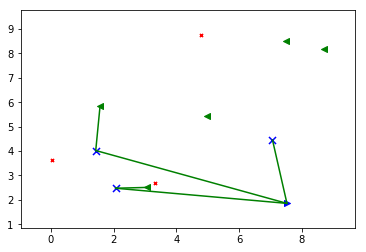

(648.0703913377971, 3, 30.0, 0.3067629094052767, 3)

In [10]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
FL_model(
    100,
    1,
    True,
    FL_range=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

In [232]:
# Meta parametric variables
nr_of_SPs = 1
nr_of_DPs = 10
nr_of_FLs = 6
areasize = 10
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs

#Instantiate EMA model
FL_EMAmodel = Model('flmodel', function=FL_model)

#Specify constants
FL_EMAmodel.constants = [
    Constant('unit_opening_costs', 100),
    Constant('unit_transport_cost', 1),
    Constant('graphical_representation', True),
    Constant('FL_range', 2),
    Constant('lorry_Speed',60) # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
]

#Specify coordinates of locations
# 0 - size area, range nr supply points
FL_EMAmodel.locations = [
    RealParameter("SPX{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("SPY{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("DPX{}".format(i), 0, areasize) for i in range(nr_of_DPs)
] + [
    RealParameter("DPY{}".format(i), 0, areasize) for i in range(nr_of_DPs)
] + [
    RealParameter("FLX{}".format(i), 0, areasize) for i in range(nr_of_FLs)
] + [RealParameter("FLY{}".format(i), 0, areasize) for i in range(nr_of_FLs)]

# Reachability of Demand Points and Facility Locations can be disrupted
FL_EMAmodel.disruptions = [
    RealParameter("DSRFL{}".format(i), -0.5, 0.5) for i in range(nr_of_FLs)
] + [
    RealParameter("DSRDP{}".format(i), -0.5, 0.5) for i in range(nr_of_DPs)
]

#Specify uncertainties
FL_EMAmodel.uncertainties = FL_EMAmodel.locations + FL_EMAmodel.disruptions

#     RealParameter('DTNN{}{}'.format(n1,n2),-0.5,0.5) # - 50% + 50% for all n, for all n

# # Specify levers
# Facility Location Operational: [0,1]
FL_EMAmodel.levers = [
    IntegerParameter("FLO{}".format(i), 0, 1) for i in range(nr_of_FLs)
]

# FL_EMAmodel.c

# Specify outcomes
FL_EMAmodel.outcomes = [
    ScalarOutcome('Total_cost', MINIZ),
    ScalarOutcome('Nr_uncovered_DPs'),
    ScalarOutcome('Total_uncovered_demand'),
    ScalarOutcome('Total_distr_time')
]

FL_EMAmodel.constraints = [
    Constraint()
]

# ScalarOutcome('operational_FL'),
    


# total_costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time,

In [32]:
IntegerParameter("test",0,1)

IntegerParameter('test', 0, 2)

In [39]:
Policy("no_FLs",**{lever.name: 0 for lever in FL_EMAmodel.levers})

{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}

In [18]:


from ema_workbench.em_framework import sample_levers

samples = sample_levers(FL_EMAmodel, 5)

for sample in samples:
    print(sample)


NameError: name 'FL_EMAmodel' is not defined

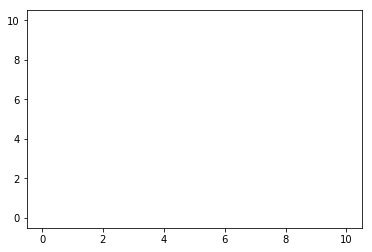

In [35]:
FL_EMAmodel.run_model(Scenario(), Policy({}))

In [29]:
random_scenario = Scenario(**{unc.name: random.uniform(0,10) for unc in FL_EMAmodel.uncertainties})

[MainProcess/INFO] performing 1 scenarios * 3 policies * 1 model(s) = 3 experiments
[MainProcess/INFO] performing experiments sequentially


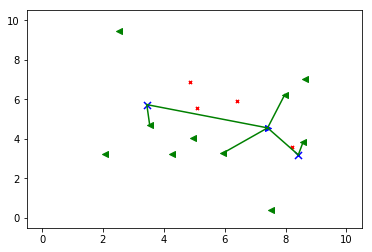

[MainProcess/INFO] 1 cases completed


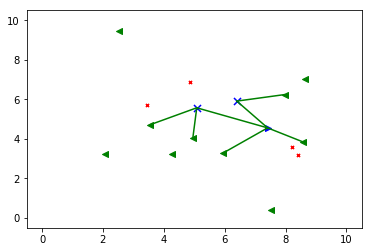

[MainProcess/INFO] 2 cases completed


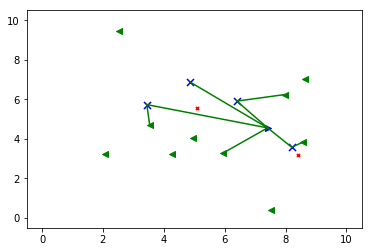

[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] experiments finished


In [35]:
from ema_workbench import Policy, perform_experiments

policy_no = Policy("No_FLs",**{lever.name: 0 for lever in FL_EMAmodel.levers})
policy_all = Policy("All_FLs",**{lever.name: 1 for lever in FL_EMAmodel.levers})

results = perform_experiments(FL_EMAmodel, random_scenario,3)


experiments, outcomes = results

In [89]:
pd.DataFrame(experiments)#[["FLO0","FLO1","FLO2","FLO3"]]

,DPX0,DPX1,DPX2,DPX3,DPX4,DPX5,DPX6,DPX7,DPX8,DPX9,...,SPY0,FLO0,FLO1,FLO2,FLO3,FLO4,FLO5,scenario_id,policy,model
0,8.511881,3.216641,7.190886,5.747872,5.591575,5.096612,1.634270,8.165164,2.712119,5.784892,...,5.212050,0,0,0,0,0,0,70,1,flmodel
1,0.659520,9.540083,0.529086,0.895843,4.775754,3.536806,8.336866,2.628721,9.053414,4.874742,...,4.590406,0,0,0,0,0,0,71,1,flmodel


In [38]:
pd.DataFrame(outcomes)

,Total_cost,operational_FL
0,441.705585,4.0
1,428.372205,4.0
2,237.854518,2.0
3,234.220134,2.0


## EMA Algorithm

Data types required:
- DF with certain variables: Locations, distances
- Data type:
    - uncertain variables: ranges, best_estimates and actual values
    - Some representation of full tree, includes:
        - Which FL at which period implemented, proportion of prioritisation objective

EMA Algorithm:

0. Instantiate
1. Optimise (Platypus / Full Factorial + nondominated
2. create policies from optimise results (python)
3. robustness analysis (EMA)
4. cluster, based on robustness analysis
5. branch / implement

In [8]:
import pandas as pd
import numpy as np
import random

In [9]:
Nepal = pd.read_excel("Data/Nepal Cities Population.xlsx", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [10]:
airports = pd.read_excel("Data/Nepal Airports.xlsx", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


In [11]:
CaseFixed = pd.DataFrame(columns = ['City', 'Xcor', "Ycor"])

In [12]:
CaseFixed

,City,Xcor,Ycor


In [7]:
CaseVariable = pd.DataFrame(columns = ['variable','lower', 'upper', 'best_estimate','actual'])

In [8]:
Case

,variable,lower,upper,actual


In [13]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

nr_of_FLs = 6
FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Decision Variables
FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

In [16]:
def create_policies(operational_fls, new_fls = 1):
    # indexes of FLs which are already operational
    opfls = [i for i,x in enumerate(operational_fls) if x == 1]
    
    # Create list of policies  
    pols = np.identity(nr_of_FLs)
    # Set already operational facilities to operational
    pols[:,opfls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(operational_fls) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    return pols

In [15]:
create_policies(oprfls)

NameError: name 'oprfls' is not defined

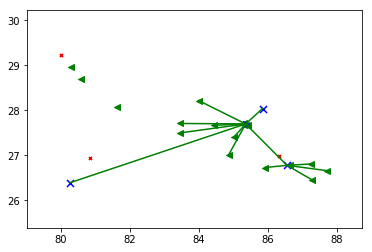

(318.49125760041863, 3, 30.0, 0.29514070303198475, 3)

In [21]:
# 1. Optimise

FL_model(
    100,
    1,
    True,
    FL_range=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# Plot Nepal map options

In [13]:
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
from descartes import PolygonPatch

In [24]:
# Get the shape of the area
gdf=ox.gdf_from_place("Nepal")
gdf=ox.project_gdf(gdf)

# Dit gedeelte is mijn code om een figuur te maken, dit ziet er bij jouw anders uit
isochrone_polys = make_iso_polys(gdf, edge_buff=25, node_buff=50, infill=True)
fig, ax = ox.plot_graph(gdf, fig_height=20, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color=nc,node_size=ns)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
#Set the shape around the network
for geometry in gdf['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
#             add_patch(patch)
            
# margin = 0.02
# west, south, east, north = gdf.unary_union.bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
    
plt.show()

NameError: name 'make_iso_polys' is not defined

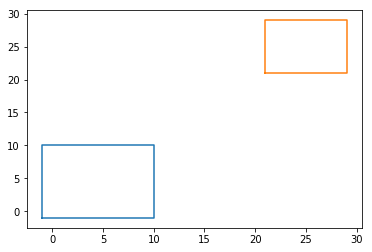

In [26]:
import numpy as np
from matplotlib import pyplot as p  #contains both numpy and pyplot
x1 = [-1, -1, 10, 10, -1]
y1 = [-1, 10, 10, -1, -1]
x2 = [21, 21, 29, 29, 21]
y2 = [21, 29, 29, 21, 21]
shapes = [[x1, y1], [x2, y2]]
for shape in shapes:
    x, y = shape
    p.plot(x, y)
p.show()

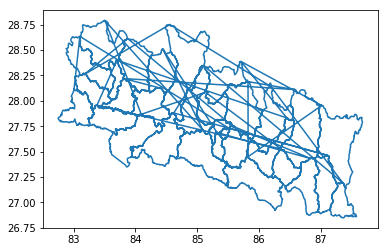

In [14]:
import matplotlib.pyplot as plt
import shapefile   

shpFilePath = "Data/Nepal_shape/31Adist_polbnda_adm3_MoFALD_HRRP_wgs84.shp"  
listx=[]
listy=[]
test = shapefile.Reader(shpFilePath)
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy)
plt.show()

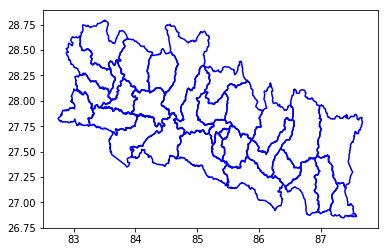

In [15]:

sf = shapefile.Reader("Data/Nepal_shape/31Adist_polbnda_adm3_MoFALD_HRRP_wgs84.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color="blue")
plt.show()

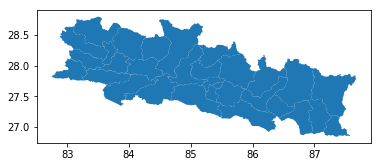

In [36]:
import geopandas
df = geopandas.read_file("Data/Nepal_shape/31Adist_polbnda_adm3_MoFALD_HRRP_wgs84.shp")
df.plot()
# df.plot()

# EMA

In [ ]:
# Meta parametric variables
nr_of_SPs = 1
nr_of_DPs = 10
nr_of_FLs = 6
areasize = 10
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs

#Instantiate EMA model
FL_EMAmodel = Model('flmodel', function=FL_model)

#Specify constants
FL_EMAmodel.constants = [
    Constant('unit_opening_costs', 100),
    Constant('unit_transport_cost', 1),
    Constant('graphical_representation', True),
    Constant('FL_range', 2),
    Constant('lorry_Speed',60) # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
]

#Specify coordinates of locations
# 0 - size area, range nr supply points
FL_EMAmodel.locations = [
    RealParameter("SPX{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("SPY{}".format(i), 0, areasize) for i in range(nr_of_SPs)
] + [
    RealParameter("DPX{}".format(i), 0, areasize) for i in range(nr_of_DPs)
] + [
    RealParameter("DPY{}".format(i), 0, areasize) for i in range(nr_of_DPs)
] + [
    RealParameter("FLX{}".format(i), 0, areasize) for i in range(nr_of_FLs)
] + [RealParameter("FLY{}".format(i), 0, areasize) for i in range(nr_of_FLs)]

# Reachability of Demand Points and Facility Locations can be disrupted
FL_EMAmodel.disruptions = [
    RealParameter("DSRFL{}".format(i), -0.5, 0.5) for i in range(nr_of_FLs)
] + [
    RealParameter("DSRDP{}".format(i), -0.5, 0.5) for i in range(nr_of_DPs)
]

#Specify uncertainties
FL_EMAmodel.uncertainties = FL_EMAmodel.locations + FL_EMAmodel.disruptions

#     RealParameter('DTNN{}{}'.format(n1,n2),-0.5,0.5) # - 50% + 50% for all n, for all n

# # Specify levers
# Facility Location Operational: [0,1]
FL_EMAmodel.levers = [
    IntegerParameter("FLO{}".format(i), 0, 1) for i in range(nr_of_FLs)
]

# FL_EMAmodel.c

# Specify outcomes
FL_EMAmodel.outcomes = [
    ScalarOutcome('Total_cost', MINIZ),
    ScalarOutcome('Nr_uncovered_DPs'),
    ScalarOutcome('Total_uncovered_demand'),
    ScalarOutcome('Total_distr_time')
]

FL_EMAmodel.constraints = [
    Constraint()
]

# ScalarOutcome('operational_FL'),
    


# total_costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time,

# Platypus optimisation

In [14]:
# imports
from platypus import NSGAII, Problem, Binary, Real, Integer

In [10]:
def FL_model(d_vars=None): # None to make compatible with EMA

    # set global operational FL
    for i in range(len(d_vars)):
        facility_locations[i].operational = d_vars[i]

    trans_costs = calc_transportation_costs(supply_points, demand_points,
                                      facility_locations, distances)

    costs = trans_costs #+ other costs
    
    objectives = [
        costs,
    ]
    constraints = [sum(d_vars),]

    return objectives, constraints

In [54]:
# nr of decision variables, number of objectives, number of constraints
problem = Problem(nr_optional_FL, 1, 1)

# Decision variables for possible facility locations
problem.types[:] = [Integer(0,1) for a in range(nr_optional_FL)]

# constraint: number of total operation FL
problem.constraints[:] = "=={}".format(max_nr_FL)
problem.function = FL_model

algorithm = NSGAII(problem)
algorithm.run(10000)

'==2'

In [17]:
from platypus import nondominated

In [55]:
a = nondominated (algorithm.result)

In [57]:
a

[Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.9886910101304

In [56]:
for i in a[0].objectives:
    print(i)

68.98869101013045


In [44]:
a[0].objectives[0]

33.50099827255527

In [46]:
set([i.objectives[0] for i in a])

{33.50099827255527}

# Creation of full network:


In [100]:
list(itertools.product([0,1], repeat=3))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]